System information (for reproducibility):

In [9]:
versioninfo()

Julia Version 1.10.3
Commit 0b4590a5507 (2024-04-30 10:59 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: macOS (arm64-apple-darwin22.4.0)
  CPU: 12 × Apple M2 Max
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, apple-m1)
Threads: 8 default, 0 interactive, 4 GC (on 8 virtual cores)
Environment:
  JULIA_NUM_THREADS = 8
  JULIA_EDITOR = code


Load packages:

In [10]:
using Pkg

Pkg.activate(pwd())
Pkg.instantiate()
Pkg.status()

  Activating project at `~/Documents/github.com/ucla-biostat-257/2024spring/slides/29-lp`


Status `~/Documents/github.com/ucla-biostat-257/2024spring/slides/29-lp/Project.toml`
  [1e616198] COSMO v0.8.9
  [13f3f980] CairoMakie v0.12.2
  [f65535da] Convex v0.16.0
  [2e9cd046] Gurobi v1.3.0
  [b8f27783] MathOptInterface v1.30.0
  [1ec41992] MosekTools v0.15.1
  [c946c3f1] SCS v2.0.0
  [9a3f8284] Random


In [11]:
using Convex, COSMO, CairoMakie, Gurobi, MathOptInterface, MosekTools, Random, SCS
const MOI = MathOptInterface

MathOptInterface

## Linear programming (LP)

* A general linear program takes the form
\begin{eqnarray*}
	&\text{minimize}& \mathbf{c}^T \mathbf{x} \\
	&\text{subject to}& \mathbf{A} \mathbf{x} = \mathbf{b} \\
	& & \mathbf{G} \mathbf{x} \preceq \mathbf{h}.
\end{eqnarray*}
Linear program is a convex optimization problem, why?

<img src="./lp.png" width="300" align="center"/>

* The **standard form** of an LP is
\begin{eqnarray*}
	&\text{minimize}& \mathbf{c}^T \mathbf{x} \\
	&\text{subject to}& \mathbf{A} \mathbf{x} = \mathbf{b} \\
	& & \mathbf{x} \succeq \mathbf{0}.
\end{eqnarray*}
To transform a general linear program into the standard form, we introduce the _slack variables_ $\mathbf{s} \succeq \mathbf{0}$ such that $\mathbf{G} \mathbf{x} + \mathbf{s} = \mathbf{h}$. Then we write $\mathbf{x} = \mathbf{x}^+ - \mathbf{x}^-$, where $\mathbf{x}^+ \succeq \mathbf{0}$ and $\mathbf{x}^- \succeq \mathbf{0}$. This yields the problem
\begin{eqnarray*}
	&\text{minimize}& \mathbf{c}^T (\mathbf{x}^+ - \mathbf{x}^-) \\
	&\text{subject to}& \mathbf{A} (\mathbf{x}^+ - \mathbf{x}^-) = \mathbf{b} \\
	& & \mathbf{G} (\mathbf{x}^+ - \mathbf{x}^-) + \mathbf{s} = \mathbf{h} \\
	& & \mathbf{x}^+ \succeq \mathbf{0}, \mathbf{x}^- \succeq \mathbf{0}, \mathbf{s} \succeq \mathbf{0}
\end{eqnarray*}
in $\mathbf{x}^+$, $\mathbf{x}^-$, and $\mathbf{s}$.

    Slack variables are often used to transform a complicated inequality constraint to simple non-negativity constraints.

* The **inequality form** of an LP is
\begin{eqnarray*}
	&\text{minimize}& \mathbf{c}^T \mathbf{x} \\
	&\text{subject to}& \mathbf{G} \mathbf{x} \preceq \mathbf{h}.
\end{eqnarray*}

* Some softwares, e.g., `solveLP` in R, require an LP be written in either standard or inequality form. However a good software should do this for you!

* A _piecewise-linear minimization_ problem
\begin{eqnarray*}
	&\text{minimize}& \max_{i=1,\ldots,m} (\mathbf{a}_i^T \mathbf{x} + b_i)
\end{eqnarray*}
can be transformed to an LP
\begin{eqnarray*}
	&\text{minimize}& t \\
	&\text{subject to}& \mathbf{a}_i^T \mathbf{x} + b_i \le t, \quad i = 1,\ldots,m,
\end{eqnarray*}
in $\mathbf{x}$ and $t$. Apparently 
$$
	\text{minimize} \max_{i=1,\ldots,m} |\mathbf{a}_i^T \mathbf{x} + b_i|
$$
and
$$
	\text{minimize} \max_{i=1,\ldots,m} (\mathbf{a}_i^T \mathbf{x} + b_i)_+
$$
are also LP.

* Any _convex optimization problem_
\begin{eqnarray*}
	&\text{minimize}& f_0(\mathbf{x}) \\
	&\text{subject to}& f_i(\mathbf{x}) \le 0, \quad i=1,\ldots,m \\
	&& \mathbf{a}_i^T \mathbf{x} = b_i, \quad i=1,\ldots,p,
\end{eqnarray*}
where $f_0,\ldots,f_m$ are convex functions, can be transformed to the _epigraph form_
\begin{eqnarray*}
	&\text{minimize}& t \\
	&\text{subject to}& f_0(\mathbf{x}) - t \le 0 \\
	& & f_i(\mathbf{x}) \le 0, \quad i=1,\ldots,m \\
	& & \mathbf{a}_i^T \mathbf{x} = b_i, \quad i=1,\ldots,p
\end{eqnarray*}
in variables $\mathbf{x}$ and $t$. That is why people often say linear program is universal.

* The _linear fractional programming_
\begin{eqnarray*}
	&\text{minimize}& \frac{\mathbf{c}^T \mathbf{x} + d}{\mathbf{e}^T \mathbf{x} + f} \\
	&\text{subject to}& \mathbf{A} \mathbf{x} = \mathbf{b} \\
	& & \mathbf{G} \mathbf{x} \preceq \mathbf{h} \\
	& & \mathbf{e}^T \mathbf{x} + f > 0
\end{eqnarray*}
can be transformed to an LP
\begin{eqnarray*}
	&\text{minimize}& \mathbf{c}^T \mathbf{y} + d z \\
	&\text{subject to}& \mathbf{G} \mathbf{y} - z \mathbf{h}  \preceq \mathbf{0} \\
	& & \mathbf{A} \mathbf{y} - z \mathbf{b} = \mathbf{0} \\
	& & \mathbf{e}^T \mathbf{y} + f z = 1 \\
	& & z \ge 0
\end{eqnarray*}
in $\mathbf{y}$ and $z$, via transformation of variables
\begin{eqnarray*}
	\mathbf{y} = \frac{\mathbf{x}}{\mathbf{e}^T \mathbf{x} + f}, \quad z = \frac{1}{\mathbf{e}^T \mathbf{x} + f}.
\end{eqnarray*}
See Section 4.3.2 of Boyd and Vandenberghe (2004) for proof.

## LP example: compressed sensing

* **Compressed sensing** [Candes and Tao (2006)](https://doi.org/10.1109/TIT.2006.885507) and [Donoho (2006)](https://doi.org/10.1109/TIT.2006.871582) tries to address a fundamental question: how to compress and transmit a complex signal (e.g., musical clips, mega-pixel images), which can be decoded to recover the original signal?

<img src="./david-donoho.jpg" width="100"/>
<img src="./emmanuel-candes.png" width="100"/>
<img src="./terrence-tao.png" width="100"/>

* Suppose a signal $\mathbf{x} \in \mathbb{R}^n$ is sparse with $s$ non-zeros. We under-sample the signal by multiplying a (flat) measurement matrix $\mathbf{y} = \mathbf{A} \mathbf{x}$, where $\mathbf{A} \in \mathbb{R}^{m\times n}$ has iid normal entries. [Candes, Romberg and Tao (2006)](https://doi.org/10.1002/cpa.20124) show that the solution to
\begin{eqnarray*}
	&\text{minimize}& \|\mathbf{x}\|_1 \\
	&\text{subject to}& \mathbf{A} \mathbf{x} = \mathbf{y}
\end{eqnarray*}
exactly recovers the true signal under certain conditions on $\mathbf{A}$ when $n \gg s$ and $m \approx s \ln(n/s)$. Why sparsity is a reasonable assumption? _Virtually all real-world images have low information content_.

<img src="./movie-scene.png" width="400"/>

* The $\ell_1$ minimization problem apparently is an LP, by writing $\mathbf{x} = \mathbf{x}^+ - \mathbf{x}^-$,
\begin{eqnarray*}
	&\text{minimize}& \mathbf{1}^T (\mathbf{x}^+ + \mathbf{x}^-)  \\
	&\text{subject to}& \mathbf{A} (\mathbf{x}^+ - \mathbf{x}^-) = \mathbf{y} \\
	& & \mathbf{x}^+ \succeq \mathbf{0}, \mathbf{x}^- \succeq \mathbf{0}.
\end{eqnarray*}

* Let's try a numerical example.

### Generate a sparse signal and sub-sampling

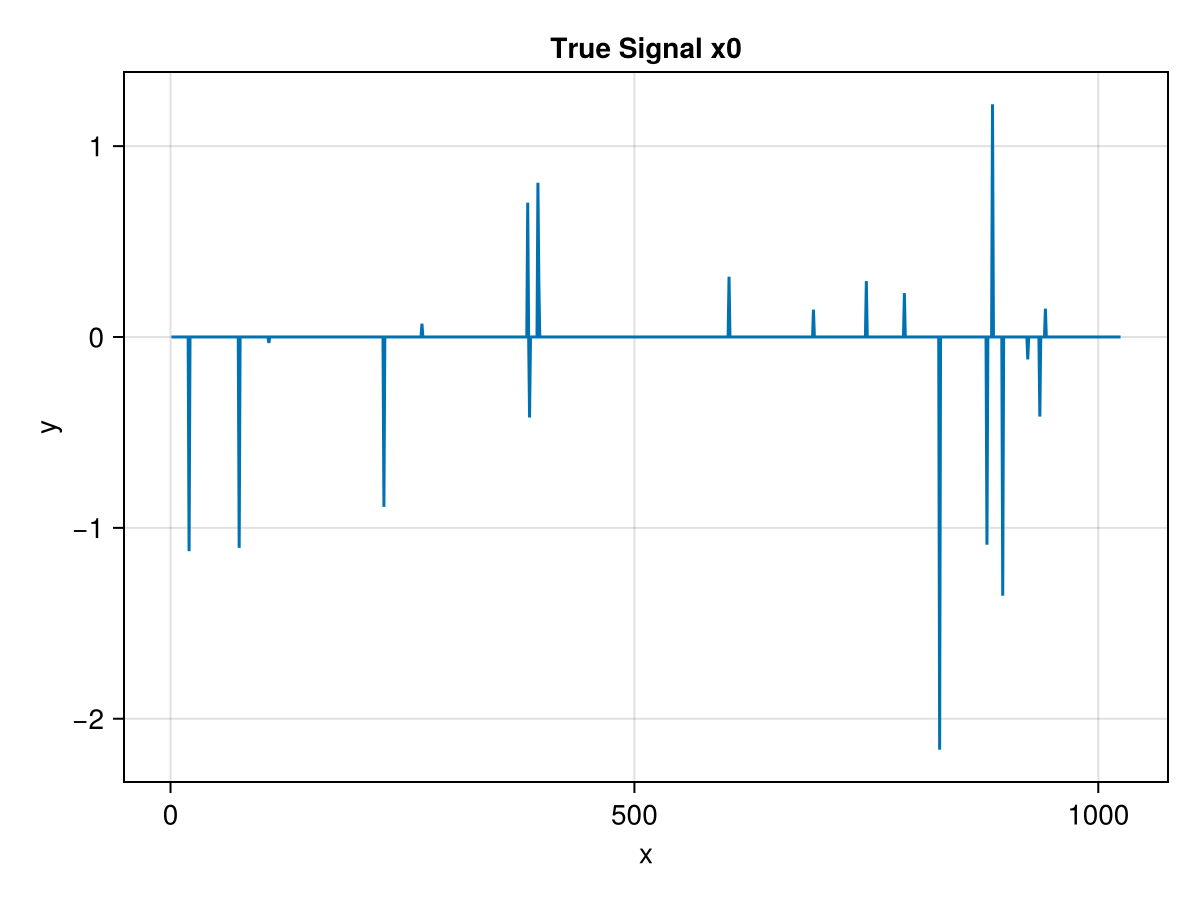

In [12]:
# random seed
Random.seed!(123)
# Size of signal
n = 1024
# Sparsity (# nonzeros) in the signal
s = 20
# Number of samples (undersample by a factor of 8) 
m = 128

# Generate and display the signal
x0 = zeros(n)
x0[rand(1:n, s)] = randn(s)
# Generate the random sampling matrix
A = randn(m, n) / m
# Subsample by multiplexing
y = A * x0

# plot the true signal
f = Figure()
Axis(
    f[1, 1], 
    title = "True Signal x0",
    xlabel = "x",
    ylabel = "y"
)
lines!(1:n, x0)
f

### Solve LP by DCP (disciplined convex programming) interface Convex.jl

Check [Convex.jl documentation](https://www.juliaopt.org/Convex.jl/stable/operations/) for a list of supported operations.

In [13]:
# # Use Mosek solver
# solver = Mosek.Optimizer()
# MOI.set(solver, MOI.RawOptimizerAttribute("LOG"), 1)

# # Use Gurobi solver
# solver = Gurobi.Optimizer()
# MOI.set(solver, MOI.RawOptimizerAttribute("OutputFlag"), 1)

# Use COSMO solver
solver = COSMO.Optimizer
# MOI.set(solver, MOI.RawOptimizerAttribute("max_iter"), 5000)

# # Use SCS solver
# solver = SCS.Optimizer()
# MOI.set(solver, MOI.RawOptimizerAttribute("verbose"), 1)

# Set up optimizaiton problem
x = Variable(n)
problem = minimize(norm(x, 1))
problem.constraints = [A * x == y]

# Solve the problem
@time solve!(problem, solver)

------------------------------------------------------------------
          COSMO v0.8.9 - A Quadratic Objective Conic Solver
                         Michael Garstka
                University of Oxford, 2017 - 2022
------------------------------------------------------------------

Problem:  x ∈ R^{2048},
          constraints: A ∈ R^{2176x2048} (135168 nnz),
          matrix size to factor: 4224x4224,
          Floating-point precision: Float64
Sets:     Nonnegatives of dim: 2048
          ZeroSet of dim: 128
Settings: ϵ_abs = 1.0e-05, ϵ_rel = 1.0e-05,
          ϵ_prim_inf = 1.0e-04, ϵ_dual_inf = 1.0e-04,
          ρ = 0.1, σ = 1e-06, α = 1.6,
          max_iter = 5000,
          scaling iter = 10 (on),
          check termination every 25 iter,
          check infeasibility every 40 iter,
          KKT system solver: QDLDL
Acc:      Anderson Type2{QRDecomp},
          Memory size = 15, RestartedMemory,	
          Safeguarded: true, tol: 2.0
Setup Time: 23.08ms

Iter:	Objective:	Pr

┌ Info: [Convex.jl] Compilation finished: 0.02 seconds, 16.537 MiB of memory allocated
└ @ Convex /Users/huazhou/.julia/packages/Convex/y7lu0/src/solution.jl:107


100	 1.1176e+01	1.1881e-01	1.2020e-02	1.0000e-01
125	 1.1305e+01	2.6256e-02	3.2067e-01	4.9044e+00
150	 1.2961e+01	4.7745e-03	5.7712e-02	4.9044e+00
175	 1.2928e+01	5.6233e-05	1.9150e-03	4.9044e+00
200	 1.2929e+01	3.1819e-08	9.1805e-01	4.0193e-01
225	 1.2929e+01	1.2218e-10	2.6023e-10	4.0193e-01

------------------------------------------------------------------
>>> Results
Status: Solved
Iterations: 235 (incl. 10 safeguarding iter)
Optimal objective: 12.93
Runtime: 0.215s (215.06ms)

  0.244424 seconds (9.11 k allocations: 97.040 MiB, 5.72% gc time)


Problem statistics
  problem is DCP         : true
  number of variables    : 1 (1_024 scalar elements)
  number of constraints  : 1 (128 scalar elements)
  number of coefficients : 131_200
  number of atoms        : 4

Solution summary
  termination status : OPTIMAL
  primal status      : FEASIBLE_POINT
  dual status        : FEASIBLE_POINT
  objective value    : 12.9288

Expression graph
  minimize
   └─ sum (convex; positive)
      └─ abs (convex; positive)
         └─ 1024-element real variable (id: 184…010)
  subject to
   └─ == constraint (affine)
      └─ + (affine; real)
         ├─ * (affine; real)
         │  ├─ …
         │  └─ …
         └─ 128×1 Matrix{Float64}


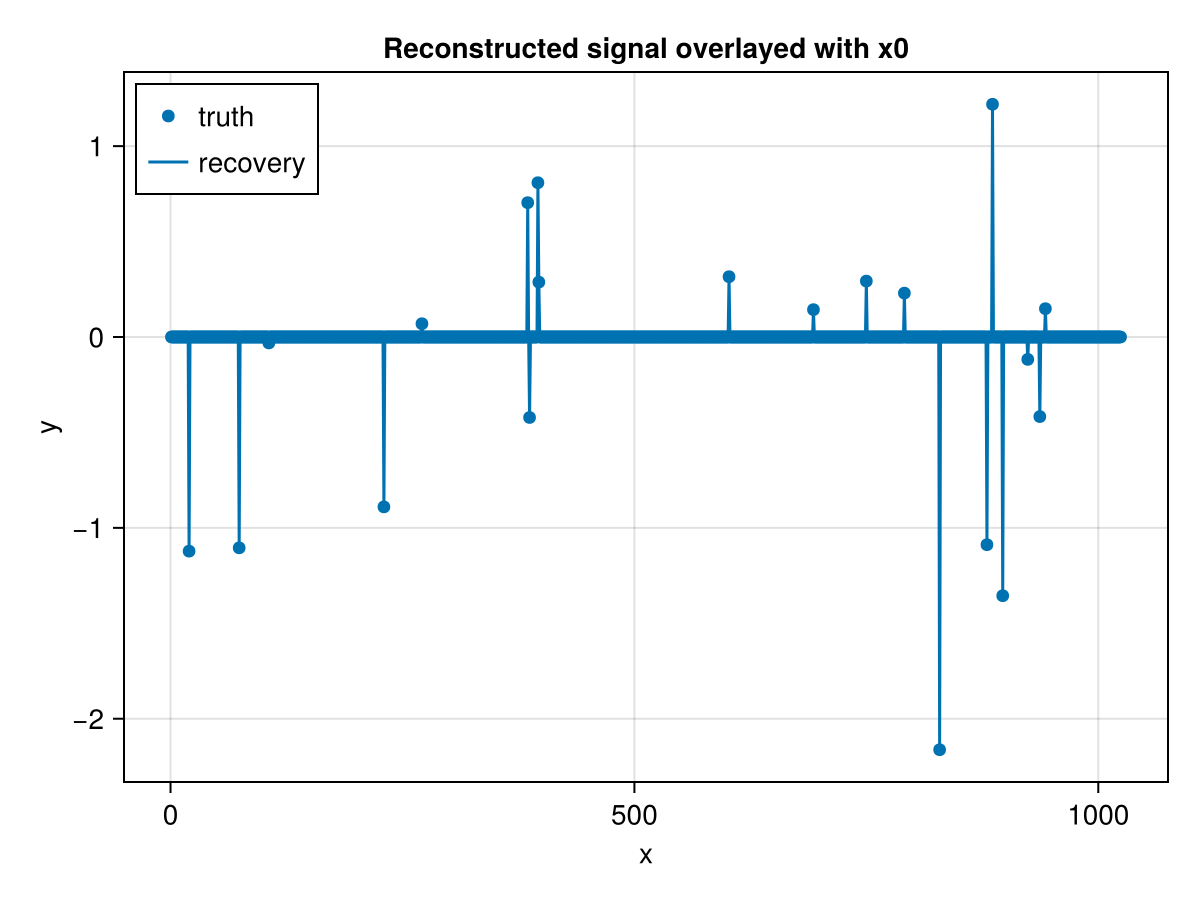

In [14]:
# Display the solution
f = Figure()
Axis(
    f[1, 1], 
    title = "Reconstructed signal overlayed with x0",
    xlabel = "x",
    ylabel = "y"
)
scatter!(1:n, x0, label = "truth")
lines!(1:n, vec(x.value), label = "recovery")
axislegend(position = :lt)
f

## LP example: quantile regression

<img src="./growth-2-20-boys.png" width="300"/>
<img src="./quantregbin3.png" width="300"/>

* In linear regression, we model the mean of response variable as a function of covariates. In many situations, the error variance is not constant, the distribution of $y$ may be asymmetric, or we simply care about the quantile(s) of response variable. Quantile regression offers a better modeling tool in these applications.


* In $\tau$-quantile regression, we minimize the loss function
\begin{eqnarray*}
	f(\beta) = \sum_{i=1}^n \rho_\tau (y_i - \mathbf{x}_i^T \beta),
\end{eqnarray*}
where $\rho_\tau(z) = z (\tau - 1_{\{z < 0\}})$. Writing $\mathbf{y}  - \mathbf{X} \beta = \mathbf{r}^+ - \mathbf{r}^-$, this is equivalent to the LP
\begin{eqnarray*}
	&\text{minimize}& \tau \mathbf{1}^T \mathbf{r}^+ + (1-\tau) \mathbf{1}^T \mathbf{r}^- \\
	&\text{subject to}& \mathbf{r}^+ - \mathbf{r}^- = \mathbf{y} - \mathbf{X} \beta \\
	& & \mathbf{r}^+ \succeq \mathbf{0}, \mathbf{r}^- \succeq \mathbf{0}
\end{eqnarray*}
in $\mathbf{r}^+$, $\mathbf{r}^-$, and $\beta$.

## LP Example: $\ell_1$ regression

* A popular method in robust statistics is the median absolute deviation (MAD) regression that minimizes the $\ell_1$ norm of the residual vector $\|\mathbf{y} - \mathbf{X} \beta\|_1$. This apparently is equivalent to the LP
\begin{eqnarray*}
	&\text{minimize}& \mathbf{1}^T (\mathbf{r}^+ + \mathbf{r}^-) \\
	&\text{subject to}& \mathbf{r}^+ - \mathbf{r}^- = \mathbf{y} - \mathbf{X} \beta \\
	& & \mathbf{r}^+ \succeq \mathbf{0}, \mathbf{r}^- \succeq \mathbf{0}
\end{eqnarray*}
in $\mathbf{r}^+$, $\mathbf{r}^-$, and $\beta$. 

    $\ell_1$ regression = MAD = 1/2-quantile regression.

## LP Example: $\ell_\infty$ regression (Chebychev approximation)

* Minimizing the worst possible residual $\|\mathbf{y} - \mathbf{X} \beta\|_\infty$ is equivalent to the LP
\begin{eqnarray*}
	&\text{minimize}& t \\
	&\text{subject to}& -t \le y_i - \mathbf{x}_i^T \beta \le t, \quad i = 1,\dots,n
\end{eqnarray*}
in variables $\beta$ and $t$.

## LP Example: Dantzig selector

* [Candes and Tao (2007)](https://www.doi.org/10.1214/009053606000001523) propose a variable selection method called the Dantzig selector that solves
\begin{eqnarray*}
	&\text{minimize}& \|\mathbf{X}^T (\mathbf{y} - \mathbf{X} \beta)\|_\infty \\
	&\text{subject to}& \sum_{j=2}^p |\beta_j| \le t,
\end{eqnarray*}
which can be transformed to an LP. Indeed they name the method after George Dantzig, who invented the simplex method for efficiently solving LP in 50s.

<img src="./george-bernard-dantzig.jpg" width="300"/>

## LP Example: 1-norm SVM

* In two-class classification problems, we are given training data $(\mathbf{x}_i, y_i)$, $i=1,\ldots,n$, where $\mathbf{x}_i \in \mathbb{R}^p$ are feature vectors and $y_i \in \{-1, 1\}$ are class labels. [Zhu, Rosset, Tibshirani, and Hastie (2004)](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=2ahUKEwi-_6C2sMLiAhUNGDQIHU1RD3MQFjAAegQIBRAC&url=https%3A%2F%2Fpapers.nips.cc%2Fpaper%2F2450-1-norm-support-vector-machines.pdf&usg=AOvVaw1cTOsmPjpxKJHCs93iLUkn) propose the 1-norm support vector machine (svm) that achieves the dual purpose of classification and feature selection. Denote the solution of the optimization problem
\begin{eqnarray*}
	&\text{minimize}& \sum_{i=1}^n \left[ 1 - y_i \left( \beta_0 + \sum_{j=1}^p x_{ij} \beta_j \right) \right]_+ \\
	&\text{subject to}& \|\beta\|_1 = \sum_{j=1}^p |\beta_j| \le t
\end{eqnarray*}
by $\hat \beta_0(t)$ and $\hat \beta(t)$. 1-norm svm classifies a future feature vector $\mathbf{x}$ by the sign of fitted model
\begin{eqnarray*}
	\hat f(\mathbf{x}) = \hat \beta_0 + \mathbf{x}^T \hat \beta.
\end{eqnarray*}

Many more applications of LP: Airport scheduling (Copenhagen airport uses Gurobi), airline flight scheduling, NFL scheduling, match.com, $\LaTeX$, ...

Apparently any loss/penalty or loss/constraint combinations of form 
$$
\{\ell_1, \ell_\infty, \text{quantile}\} \times \{\ell_1, \ell_\infty, \text{quantile}\},
$$
possibly with affine (equality and/or inequality) constraints, can be formulated as an LP.